![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# Model-Agnostic Interpretation with LIME for Image Analysis

In this notebook, we will demonstrate how to use the Local Interpretable Model-agnostic Explanations (LIME) method introduced in 2016 in the paper entitled "Why should I trust you?: Explaining the predictions of any classifier" by [Rubiero et. al.](https://arxiv.org/abs/1602.04938).

We will focus on how to apply this method and interpret its results for image classification models.

--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/master/xai-model-agnostic/Tutorial_SHAP_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive
# !git clone --branch Juelich-2023 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
# %cd XAI-Tutorials/xai-model-agnostic
# %pip install lime

### Imports

Let's start with importing all required Python packages.

In [1]:
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
#import os, json
import utils

from lime import lime_image
#from PIL import Image
from skimage.segmentation import mark_boundaries

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

## Data and Model Loading

Let's use an image we have in our 'data_and_models' folder, and a pretrained model

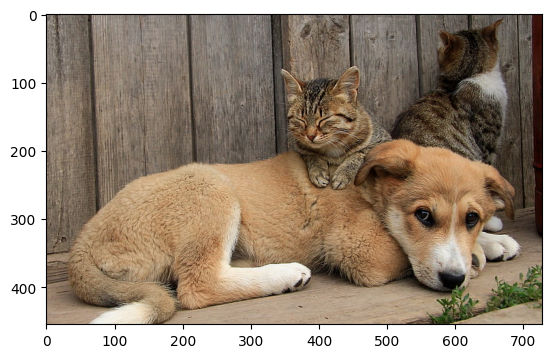

In [2]:
path_to_img = '../data_and_models/images/cat_and_dog.jpg'
img = utils.get_image(path_to_img)
plt.imshow(img)

## Now, what does my model actually think is important in the data?

We prepared a small [Introduction to LIME](https://xai-tutorials.readthedocs.io/en/latest/_model_agnostic_xai/lime.html) for you, to help you understand how this method works.

TO DO: add theoretical explanation


In [3]:
#TO DO move transofrmation into utils
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

Model definition: we use a pre-trained model

In [4]:
model = models.inception_v3(pretrained=True)

/Users/donatella.cea/opt/anaconda3/envs/XAI-course/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/donatella.cea/opt/anaconda3/envs/XAI-course/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def batch_predict(images):
    model.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [6]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


287

We will use the `LimeImageExplainer()` class.

TO DO: explain details

In [7]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                         batch_predict, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification fun

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Plot image + LIME mask

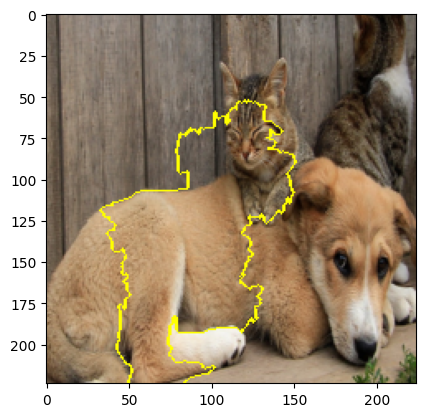

In [8]:
# Plot mask positive contributions
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=5,
    hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)


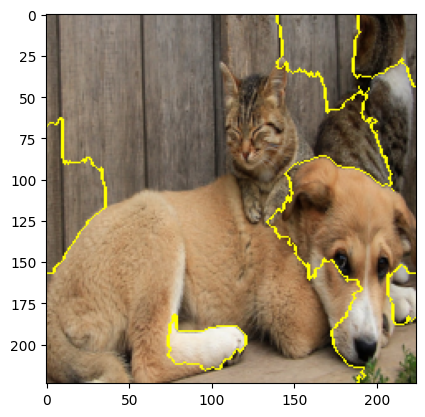

In [9]:
#Plot mask negative contributions
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=False,
    min_weight=0
)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

<font color='green'>

#### Question 1: Which are the pros and cons of LIME?

<font color='grey'>

#### Your Answer: 

From Molnar
Pros:
1. Use of surrogate model: Even if you replace the underlying machine learning model, you can still use the same local, interpretable model for an explanation. Suppose the people looking at the explanations understand decision trees best. Because you use local surrogate models, you use decision trees as explanations without actually having to use a decision tree to make the predictions. For example, you can use a SVM. And if it turns out that an XGBoost model works better, you can replace the SVM and still use a decision tree to explain the predictions.
2. LIME is one of the few methods that work for tabular data, text, and images.
3. The fidelity measure (how well the interpretable model approximates the black box predictions) gives us a good idea of how reliable the interpretable model is in explaining the black box predictions in the neighborhood of the data instance of interest.
4. Easy implementation.

Cons:
1. The correct definition of the neighborhood is a very big, unsolved problem when using LIME with tabular data. In my opinion, it is the biggest problem with LIME and the reason why I would recommend using LIME only with great care. For each application, you have to try different kernel settings and see for yourself if the explanations make sense. Unfortunately, this is the best advice I can give to find good kernel widths.
2. Sampling could be improved in the current implementation of LIME. Data points are sampled from a Gaussian distribution, ignoring the correlation between features. This can lead to unlikely data points which can then be used to learn local explanation models.
3. The complexity of the explanation model has to be defined in advance. This is just a small complaint because in the end the user always has to define the compromise between fidelity and sparsity.
4. Another really big problem is the instability of the explanations due to the random process behind the creation of the neighborhood dataset.
5. LIME explanations can be manipulated by the data scientist to hide biases 52. The possibility of manipulation makes it more difficult to trust explanations generated with LIME.


<font color='green'>

#### Question 2: TO DO

<font color='grey'>

#### Your Answer: 